In [159]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import statsmodels.api as sm

DATA_DIR = Path('.')
%matplotlib inline

In [160]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams["axes.formatter.useoffset"] = False

In [161]:
pd.set_option('display.max_columns', None)

## Read in data + clean up

In [162]:
with pd.ExcelFile(DATA_DIR / 'royalty analysis by network for python.xlsx') as xls:
    t1 = pd.read_excel(xls, 'Raw', header=0, index_col=1)

# Aggregate at country and network level

In [163]:
t1 = t1.reset_index().copy()

In [164]:
t1 = t1.groupby(['Country', 'Network']).sum()

In [165]:
t1['OECD'] = t1['OECD'].apply(lambda x: 1 if x > 0 else 0)

In [166]:
t1 = t1.reset_index().set_index('Country').copy()
t1.head()

,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD
Country,,,,,,,,,,,
Argentina,2,7.206888e+06,38047.64,7.244936e+06,2223587.17,8.025372e+05,3.686176e+05,561243.49,136.0,152591.99,0
Argentina,4,2.798736e+06,97265.43,2.896001e+06,87726.45,-1.065093e+05,0.000000e+00,569887.45,18.0,77864.71,0
Australia,1,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1
Australia,2,5.129404e+07,-317104.60,5.097694e+07,10414986.24,2.787998e+06,3.286403e+06,1744697.85,327.0,1164760.80,1
Australia,3,3.473822e+07,-78688.68,3.465953e+07,1345620.37,5.405624e+05,5.206699e+05,2893268.44,54.0,417318.36,1


## Read in CT rates

In [167]:
# Read in CT rates data
with pd.ExcelFile(DATA_DIR / 'CT rates uptp2016.xlsx') as xls:
    ctrates = pd.read_excel(xls, 'Raw', header=0, index_col=0)

In [168]:
# For countries missing 2016 CT rates, replace with their 2015 value (e.g. Switzerland)
ctrates.loc[ctrates[2016].isnull(), 2016] = ctrates.loc[ctrates[2016].isnull(), 2015]

In [169]:
# Which countries in t1 not in ctrates?
set(t1.index).difference(set(ctrates.index))

{'Korea', 'Puerto Rico', 'Slovak Republic'}

In [170]:
# Rename these
country_name_map = {
    'Hong Kong SAR': 'Hong Kong',
    'Korea, Republic of': 'Korea',
    'Slovakia': 'Slovak Republic'
} 
ctrates.index = pd.Series(ctrates.index).apply(lambda x: country_name_map[x] if x in country_name_map else x)

In [171]:
set(t1.index).difference(set(ctrates.index))

{'Puerto Rico'}

In [172]:
puerto_rico = pd.DataFrame({'Location': ['Puerto Rico'], 2016: [39]}).set_index('Location')

In [173]:
ctrates = ctrates.append(puerto_rico)

In [174]:
t1 = t1.reset_index()

In [175]:
t1.head()

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD
0,Argentina,2,7.206888e+06,38047.64,7.244936e+06,2223587.17,8.025372e+05,3.686176e+05,561243.49,136.0,152591.99,0
1,Argentina,4,2.798736e+06,97265.43,2.896001e+06,87726.45,-1.065093e+05,0.000000e+00,569887.45,18.0,77864.71,0
2,Australia,1,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1
3,Australia,2,5.129404e+07,-317104.60,5.097694e+07,10414986.24,2.787998e+06,3.286403e+06,1744697.85,327.0,1164760.80,1
4,Australia,3,3.473822e+07,-78688.68,3.465953e+07,1345620.37,5.405624e+05,5.206699e+05,2893268.44,54.0,417318.36,1


In [176]:
# Get rid of indexes
t1.columns = ['Country'] + list(t1.columns.values)[1:]

In [177]:
ctrates = ctrates.reset_index()

In [178]:
ctrates = ctrates[['Location', 2016]]

In [179]:
ctrates.columns = ['Country', 'CTRate']

In [180]:
# Merge ctrates in
t1 = pd.merge(left=t1, right=ctrates, on='Country')

# Ratios

In [181]:
t1.columns

Index(['Country', 'Network', 'Unrelated Parties Revenue',
       'Related Parties Revenue', 'Total Revenue', 'Profit (Loss) Before Tax',
       'Income Tax Accrued - CY', 'Income Tax Paid including WHT',
       'Stated Capital', 'Number of Employees', 'Tangible Assets', 'OECD',
       'CTRate'],
      dtype='object')

In [182]:
# CTRate is current percentage out of 100
t1['CTRate'] = t1.CTRate.apply(lambda x: x / 100)

In [183]:
# Effective Tax Rate
t1['ETR'] = t1['Income Tax Paid including WHT'] / t1['Profit (Loss) Before Tax']

In [184]:
# Tax Elasticity
t1['TaxElasticity'] = t1['ETR'] / t1['CTRate']

In [185]:
# Operating Margin
t1['OM'] = t1['Profit (Loss) Before Tax'] / t1['Total Revenue']

In [186]:
# Related Party Revenue Intensity
t1['RPInt'] = t1['Related Parties Revenue'] / t1['Total Revenue']

In [187]:
# Employee Intensity
t1['AssetPerEE'] = t1['Tangible Assets'] / t1['Number of Employees']
t1['PBTPerEE'] = t1['Profit (Loss) Before Tax'] / t1['Number of Employees']

In [188]:
# Return On Capital
t1['ROC'] = t1['Profit (Loss) Before Tax'] / t1['Stated Capital']

In [189]:
t1.head()

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC
0,Argentina,2,7.206888e+06,38047.64,7.244936e+06,2223587.17,8.025372e+05,3.686176e+05,561243.49,136.0,152591.99,0,0.35,0.165776,0.473646,0.306916,0.005252,1121.999926,16349.905662,3.961894
1,Argentina,4,2.798736e+06,97265.43,2.896001e+06,87726.45,-1.065093e+05,0.000000e+00,569887.45,18.0,77864.71,0,0.35,0.000000,0.000000,0.030292,0.033586,4325.817222,4873.691667,0.153936
2,Australia,1,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1,0.30,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,0.273596
3,Australia,2,5.129404e+07,-317104.60,5.097694e+07,10414986.24,2.787998e+06,3.286403e+06,1744697.85,327.0,1164760.80,1,0.30,0.315546,1.051819,0.204308,-0.006221,3561.959633,31850.110826,5.969507
4,Australia,3,3.473822e+07,-78688.68,3.465953e+07,1345620.37,5.405624e+05,5.206699e+05,2893268.44,54.0,417318.36,1,0.30,0.386937,1.289789,0.038824,-0.002270,7728.117778,24918.895741,0.465087


## Import activities data

> **NOTE:** Commenting this all out as we don't have activity data at network-country level.

In [190]:
#with pd.ExcelFile(DATA_DIR / '2016 CbC Report Table 2 used for python.xlsx') as xls:
#    t2 = pd.read_excel(xls, sheetname='Table 2', header=1)

In [191]:
# Drop cols we don't need
#for col in ['Reviewer', '10/50 or CFC', 'Tax Jurisdiction', 'LEN #', 'Other- Specify',
#            'Number of full time equivalent employees at year-end',
#            'Number of full time equivalent contractors/consultants at year-end']:
#    del t2[col]

In [192]:
# Drop dormant companies
#print(t2.Dormant.unique())
#t2 = t2[t2['Dormant'].str.lower() != 'yes'].copy()
#print(t2.Dormant.unique())
#del t2['Dormant']

In [193]:
# Coerce activities to numeric
#activity_cols = [
#    'Research and Development',
#    'Holding or Management of Intellectual Property',
#    'Purchasing or Procurement', 'Manufacturing or Production',
#    'Sales/ Marketing or Distribution',
#    'Administrative/Management or Support Services',
#    'Provision of Services to Unrelated Parties', 'Internal Group Finance',
#    'Regulated Financial Services', 'Insurance',
#    'Holding Shares or Other Equity Instruments'
#]

In [194]:
# Options...
#np.unique(t2[activity_cols])

In [195]:
#for activity_col in activity_cols:
#    t2[activity_col] = t2[activity_col].apply(lambda x: str(x).lower().replace(' ', '')).map({'yes': 1, 'no': 0})

In [196]:
# Aggregate avg activity by country
#t2_country = t2.groupby('Country Of Business').mean().reset_index()

In [197]:
# Let's have a look
#t2_country.head()

In [198]:
# What's the difference here?
#t2_country.sort_values('Sales/ Marketing or Distribution').head()

## Join t1 and t2

In [199]:
# What's in t1 and not in t2?
#set(t1['Country']) - set(t2_country['Country Of Business'])

In [200]:
# What's in t2 and not in t1?
#set(t2_country['Country Of Business']) - set(t1['Country'])

In [201]:
# Can we drop Tanzania from t1? Yes...by looks of it.
#t1[t1['Country'] == 'Tanzania']

In [202]:
# Drop Tanzania from t1
#t1 = t1[t1['Country'] != 'Tanzania'].copy()

In [203]:
# Can we drop Barbados from t2?
#t2[t2['Country Of Business'] == 'Barbados']

In [204]:
# Drop Barbados from t2_country
#t2_country = t2_country[t2_country['Country Of Business'] != 'Barbados'].copy()

In [205]:
# Rename Korea, Qatar, Slovakia in t2
#country_mapping = {
#    'Korea, Republic of': 'Korea',
#    'Qatar (Katar)': 'Qatar',
#    'Slovakia': 'Slovak Republic'
#}
#t2_country['Country Of Business'] = t2_country['Country Of Business'].apply(
#    lambda x: country_mapping[x] if x in country_mapping else x
#)

In [206]:
# CHECK: What's in t1 and not in t2?
#set(t1['Country']) - set(t2_country['Country Of Business'])

In [207]:
# CHECK: What's in t2 and not in t1?
#set(t2_country['Country Of Business']) - set(t1['Country'])

In [208]:
# Ready to merge!
#df = pd.merge(
#    left=t1,
#    right=t2_country,
#    left_on='Country',
#    right_on='Country Of Business'
#    )

In [209]:
#del df['Country Of Business']

In [210]:
df = t1.copy()
df.head()

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC
0,Argentina,2,7.206888e+06,38047.64,7.244936e+06,2223587.17,8.025372e+05,3.686176e+05,561243.49,136.0,152591.99,0,0.35,0.165776,0.473646,0.306916,0.005252,1121.999926,16349.905662,3.961894
1,Argentina,4,2.798736e+06,97265.43,2.896001e+06,87726.45,-1.065093e+05,0.000000e+00,569887.45,18.0,77864.71,0,0.35,0.000000,0.000000,0.030292,0.033586,4325.817222,4873.691667,0.153936
2,Australia,1,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1,0.30,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,0.273596
3,Australia,2,5.129404e+07,-317104.60,5.097694e+07,10414986.24,2.787998e+06,3.286403e+06,1744697.85,327.0,1164760.80,1,0.30,0.315546,1.051819,0.204308,-0.006221,3561.959633,31850.110826,5.969507
4,Australia,3,3.473822e+07,-78688.68,3.465953e+07,1345620.37,5.405624e+05,5.206699e+05,2893268.44,54.0,417318.36,1,0.30,0.386937,1.289789,0.038824,-0.002270,7728.117778,24918.895741,0.465087


## Add network names and drop Corp

In [211]:
df = df[df['Network'] != 9].copy()

In [212]:
network_map = {
    1: 'BBDO',
    2: 'DDB',
    3: 'DAS',
    4: 'TBWA',
    5: 'OMG',
}
df['Network'] = df['Network'].map(network_map)
df.head()

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC
0,Argentina,DDB,7.206888e+06,38047.64,7.244936e+06,2223587.17,8.025372e+05,3.686176e+05,561243.49,136.0,152591.99,0,0.35,0.165776,0.473646,0.306916,0.005252,1121.999926,16349.905662,3.961894
1,Argentina,TBWA,2.798736e+06,97265.43,2.896001e+06,87726.45,-1.065093e+05,0.000000e+00,569887.45,18.0,77864.71,0,0.35,0.000000,0.000000,0.030292,0.033586,4325.817222,4873.691667,0.153936
2,Australia,BBDO,1.930092e+08,6559396.72,1.995686e+08,12759512.97,2.274793e+07,8.424168e+06,46636286.77,964.4,5498738.89,1,0.30,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,0.273596
3,Australia,DDB,5.129404e+07,-317104.60,5.097694e+07,10414986.24,2.787998e+06,3.286403e+06,1744697.85,327.0,1164760.80,1,0.30,0.315546,1.051819,0.204308,-0.006221,3561.959633,31850.110826,5.969507
4,Australia,DAS,3.473822e+07,-78688.68,3.465953e+07,1345620.37,5.405624e+05,5.206699e+05,2893268.44,54.0,417318.36,1,0.30,0.386937,1.289789,0.038824,-0.002270,7728.117778,24918.895741,0.465087


## Bring in royalties

In [213]:
with pd.ExcelFile(DATA_DIR / 'royalty analysis by network for python.xlsx') as xls:
    royalty = pd.read_excel(xls, 'Royalty summary', header=0)

In [214]:
# Cleanup
royalty = royalty[['Paying country', 'Network', 'Ave Roy']].copy()
royalty

,Paying country,Network,Ave Roy
0,Australia,TBWA,2.375
1,Hong Kong,TBWA,2.000
2,China,TBWA,2.000
3,India,TBWA,3.000
4,Thailand,TBWA,2.000
5,Singapore,TBWA,2.000
6,Korea,TBWA,2.000
7,New Zealand,TBWA,3.500
8,Philippines,TBWA,1.500
9,Malaysia,TBWA,1.500


In [215]:
# What's in royalties_country_avg and not in df?
set(royalty['Paying country']) - set(df['Country'])

{'UK '}

In [216]:
# Map country names to df
country_mapping = {'Germany ': 'Germany', 'UK ': 'United Kingdom'}
royalty['Paying country'] = royalty['Paying country'].apply(
    lambda x: country_mapping[x] if x in country_mapping else x
)
royalty

,Paying country,Network,Ave Roy
0,Australia,TBWA,2.375
1,Hong Kong,TBWA,2.000
2,China,TBWA,2.000
3,India,TBWA,3.000
4,Thailand,TBWA,2.000
5,Singapore,TBWA,2.000
6,Korea,TBWA,2.000
7,New Zealand,TBWA,3.500
8,Philippines,TBWA,1.500
9,Malaysia,TBWA,1.500


In [217]:
# CHECK: What's in royalties_country_avg and not in df?
set(royalty['Paying country']) - set(df['Country'])

set()

In [218]:
royalty

,Paying country,Network,Ave Roy
0,Australia,TBWA,2.375
1,Hong Kong,TBWA,2.000
2,China,TBWA,2.000
3,India,TBWA,3.000
4,Thailand,TBWA,2.000
5,Singapore,TBWA,2.000
6,Korea,TBWA,2.000
7,New Zealand,TBWA,3.500
8,Philippines,TBWA,1.500
9,Malaysia,TBWA,1.500


In [219]:
# Add this to df
df = pd.merge(
    left=df,
    right=royalty,
    left_on=['Country', 'Network'],
    right_on=['Paying country', 'Network'],
    how='left'
)

In [220]:
del df['Paying country']
df['royalty'] = df['Ave Roy'].fillna(0.0)
del df['Ave Roy']

In [221]:
df

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC,royalty
0,Argentina,DDB,7.206888e+06,3.804764e+04,7.244936e+06,2.223587e+06,8.025372e+05,3.686176e+05,5.612435e+05,136.00,1.525920e+05,0,0.3500,0.165776,0.473646,0.306916,0.005252,1121.999926,16349.905662,3.961894e+00,0.000
1,Argentina,TBWA,2.798736e+06,9.726543e+04,2.896001e+06,8.772645e+04,-1.065093e+05,0.000000e+00,5.698875e+05,18.00,7.786471e+04,0,0.3500,0.000000,0.000000,0.030292,0.033586,4325.817222,4873.691667,1.539364e-01,0.000
2,Australia,BBDO,1.930092e+08,6.559397e+06,1.995686e+08,1.275951e+07,2.274793e+07,8.424168e+06,4.663629e+07,964.40,5.498739e+06,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,2.735962e-01,0.000
3,Australia,DDB,5.129404e+07,-3.171046e+05,5.097694e+07,1.041499e+07,2.787998e+06,3.286403e+06,1.744698e+06,327.00,1.164761e+06,1,0.3000,0.315546,1.051819,0.204308,-0.006221,3561.959633,31850.110826,5.969507e+00,2.000
4,Australia,DAS,3.473822e+07,-7.868868e+04,3.465953e+07,1.345620e+06,5.405624e+05,5.206699e+05,2.893268e+06,54.00,4.173184e+05,1,0.3000,0.386937,1.289789,0.038824,-0.002270,7728.117778,24918.895741,4.650866e-01,0.000
5,Australia,TBWA,3.880965e+07,1.336246e+06,4.014589e+07,4.247369e+06,1.211072e+06,1.329550e+06,6.072458e+06,245.00,3.038840e+06,1,0.3000,0.313029,1.043430,0.105798,0.033285,12403.426735,17336.199020,6.994480e-01,2.375
6,Australia,OMG,1.076875e+08,3.308678e+06,1.109962e+08,1.556787e+07,4.075269e+06,4.532237e+06,3.626347e+05,746.00,2.909359e+06,1,0.3000,0.291128,0.970425,0.140256,0.029809,3899.945201,20868.461139,4.292991e+01,0.000
7,Austria,BBDO,7.532889e+06,6.244967e+04,7.595339e+06,1.323572e+06,3.239944e+05,5.154408e+05,9.234750e+04,67.00,2.642088e+05,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,19754.801493,1.433251e+01,0.000
8,Austria,DDB,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
9,Austria,DAS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


## Prepare df for classification

In [222]:
# Dummy country
#country_dummies = pd.get_dummies(df['Country'])
#model_df = pd.concat([df, country_dummies.ix[:, 1:]], axis=1)

In [277]:
# Dummy network
network_dummies = pd.get_dummies(df['Network'])
df = pd.concat([df, network_dummies], axis=1)

In [223]:
# Coerce royalty to binary 1/0
df['charge_royalty'] = (df['royalty'] > 0).astype(int)

In [278]:
df

,Country,Network,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Accrued - CY,Income Tax Paid including WHT,Stated Capital,Number of Employees,Tangible Assets,OECD,CTRate,ETR,TaxElasticity,OM,RPInt,AssetPerEE,PBTPerEE,ROC,royalty,charge_royalty,BBDO,DAS,DDB,OMG,TBWA
0,Argentina,DDB,7.206888e+06,3.804764e+04,7.244936e+06,2.223587e+06,8.025372e+05,3.686176e+05,5.612435e+05,136.00,1.525920e+05,0,0.3500,0.165776,0.473646,0.306916,0.005252,1121.999926,16349.905662,3.961894e+00,0.000,0,0,0,1,0,0
1,Argentina,TBWA,2.798736e+06,9.726543e+04,2.896001e+06,8.772645e+04,-1.065093e+05,0.000000e+00,5.698875e+05,18.00,7.786471e+04,0,0.3500,0.000000,0.000000,0.030292,0.033586,4325.817222,4873.691667,1.539364e-01,0.000,0,0,0,0,0,1
2,Australia,BBDO,1.930092e+08,6.559397e+06,1.995686e+08,1.275951e+07,2.274793e+07,8.424168e+06,4.663629e+07,964.40,5.498739e+06,1,0.3000,0.660226,2.200755,0.063935,0.032868,5701.720127,13230.519463,2.735962e-01,0.000,0,1,0,0,0,0
3,Australia,DDB,5.129404e+07,-3.171046e+05,5.097694e+07,1.041499e+07,2.787998e+06,3.286403e+06,1.744698e+06,327.00,1.164761e+06,1,0.3000,0.315546,1.051819,0.204308,-0.006221,3561.959633,31850.110826,5.969507e+00,2.000,1,0,0,1,0,0
4,Australia,DAS,3.473822e+07,-7.868868e+04,3.465953e+07,1.345620e+06,5.405624e+05,5.206699e+05,2.893268e+06,54.00,4.173184e+05,1,0.3000,0.386937,1.289789,0.038824,-0.002270,7728.117778,24918.895741,4.650866e-01,0.000,0,0,1,0,0,0
5,Australia,TBWA,3.880965e+07,1.336246e+06,4.014589e+07,4.247369e+06,1.211072e+06,1.329550e+06,6.072458e+06,245.00,3.038840e+06,1,0.3000,0.313029,1.043430,0.105798,0.033285,12403.426735,17336.199020,6.994480e-01,2.375,1,0,0,0,0,1
6,Australia,OMG,1.076875e+08,3.308678e+06,1.109962e+08,1.556787e+07,4.075269e+06,4.532237e+06,3.626347e+05,746.00,2.909359e+06,1,0.3000,0.291128,0.970425,0.140256,0.029809,3899.945201,20868.461139,4.292991e+01,0.000,0,0,0,0,1,0
7,Austria,BBDO,7.532889e+06,6.244967e+04,7.595339e+06,1.323572e+06,3.239944e+05,5.154408e+05,9.234750e+04,67.00,2.642088e+05,1,0.2500,0.389432,1.557727,0.174261,0.008222,3943.415522,19754.801493,1.433251e+01,0.000,0,1,0,0,0,0
8,Austria,DDB,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0,0,0,1,0,0
9,Austria,DAS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,1,0.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0,0,1,0,0,0


## Build logit classification model

In [225]:
from sklearn import linear_model

In [226]:
# Tunisia contains NaNs and infs, it has zero revenue, so drop it
df = df[df['Country'] != 'Tunisia'].copy()

# Drop the US
#df = df[df['Country'] != 'United States'].copy()

In [227]:
#country_features = list(country_dummies.ix[:, 1:].columns.values)

In [228]:
df.columns

Index(['Country', 'Network', 'Unrelated Parties Revenue',
       'Related Parties Revenue', 'Total Revenue', 'Profit (Loss) Before Tax',
       'Income Tax Accrued - CY', 'Income Tax Paid including WHT',
       'Stated Capital', 'Number of Employees', 'Tangible Assets', 'OECD',
       'CTRate', 'ETR', 'TaxElasticity', 'OM', 'RPInt', 'AssetPerEE',
       'PBTPerEE', 'ROC', 'royalty', 'charge_royalty'],
      dtype='object')

In [229]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
]

In [230]:
X = df[features]
y = df['charge_royalty']

In [231]:
model = linear_model.LogisticRegression()

In [232]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [233]:
model.score(X, y)

0.75909090909090904

In [234]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_[0], 'abs_coef': np.abs(model.coef_[0])},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
4,Tangible Assets,-1.144206e-07,1.144206e-07
1,Profit (Loss) Before Tax,-7.143648e-08,7.143648e-08
2,Stated Capital,-1.142793e-08,1.142793e-08
0,Unrelated Parties Revenue,4.953319e-09,4.953319e-09
3,Number of Employees,-7.524381e-11,7.524381e-11
5,OECD,-7.674488e-13,7.674488e-13


### Interpretation
Controlling for all other variables...
- The log-odds of charging royalty increases by -8.078418e-07 for every additional employee
  - i.e. more employees means less likely to charge royalty

In [235]:
# P(charge_royalty | OECD) = 19/142 = 13%
# P(charge_royalty | not OECD) = 5/78 = 6%
pd.crosstab(df['OECD'], df['charge_royalty'])

charge_royalty,0,1
OECD,,
0,73,5
1,123,19


## Build regression model (`royalty ~ .`)

In [327]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
    #'BBDO',
    #'DDB',
    #'DAS',
    #'TWBA',
]

In [328]:
X = df[features]
y = df['royalty']

In [329]:
model = linear_model.LinearRegression()

In [330]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [331]:
model.score(X, y)

0.032393457117023794

In [332]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_, 'abs_coef': np.abs(model.coef_)},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
5,OECD,2.590616e-01,2.590616e-01
3,Number of Employees,2.611659e-04,2.611659e-04
4,Tangible Assets,-1.624214e-08,1.624214e-08
2,Stated Capital,3.255945e-09,3.255945e-09
1,Profit (Loss) Before Tax,8.581714e-10,8.581714e-10
0,Unrelated Parties Revenue,-2.441598e-10,2.441598e-10


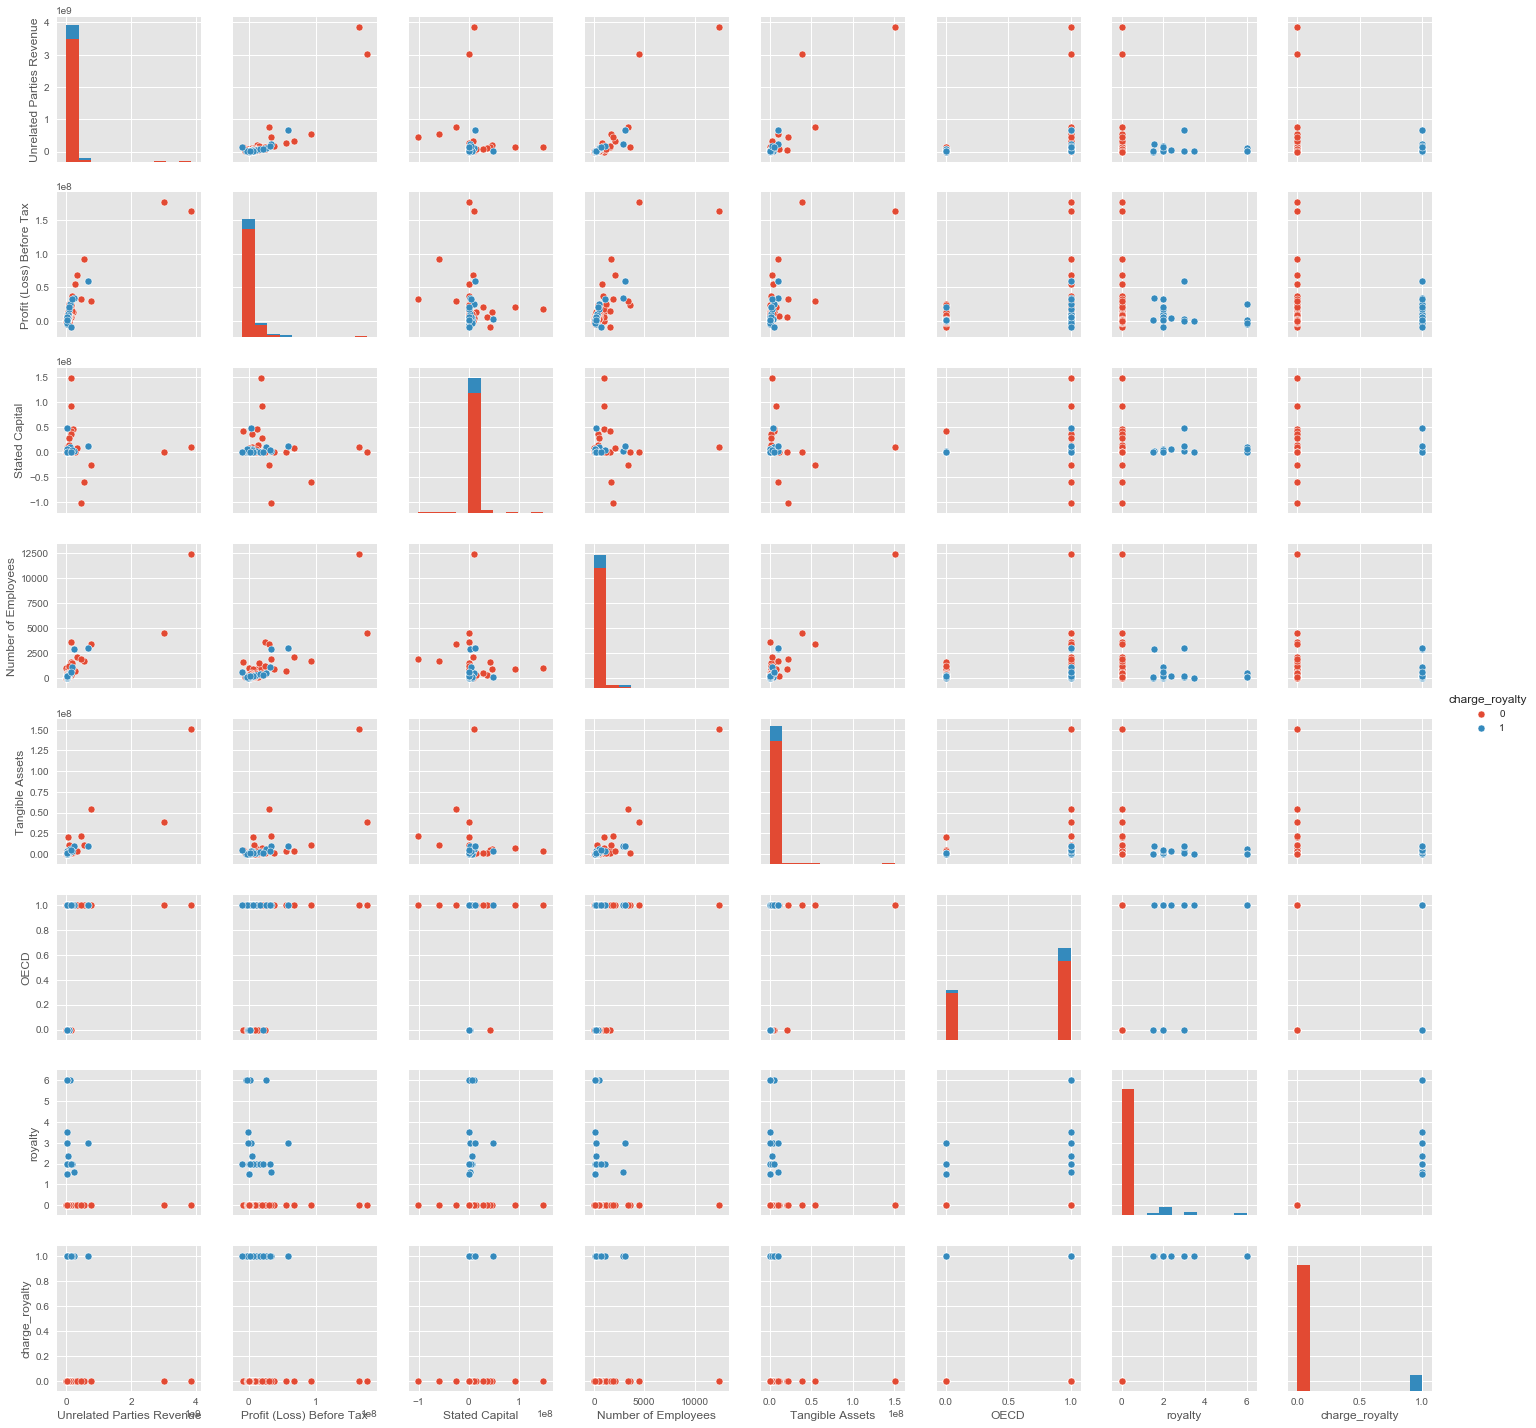

In [333]:
sns.pairplot(df[features + ['royalty', 'charge_royalty']], hue='charge_royalty')

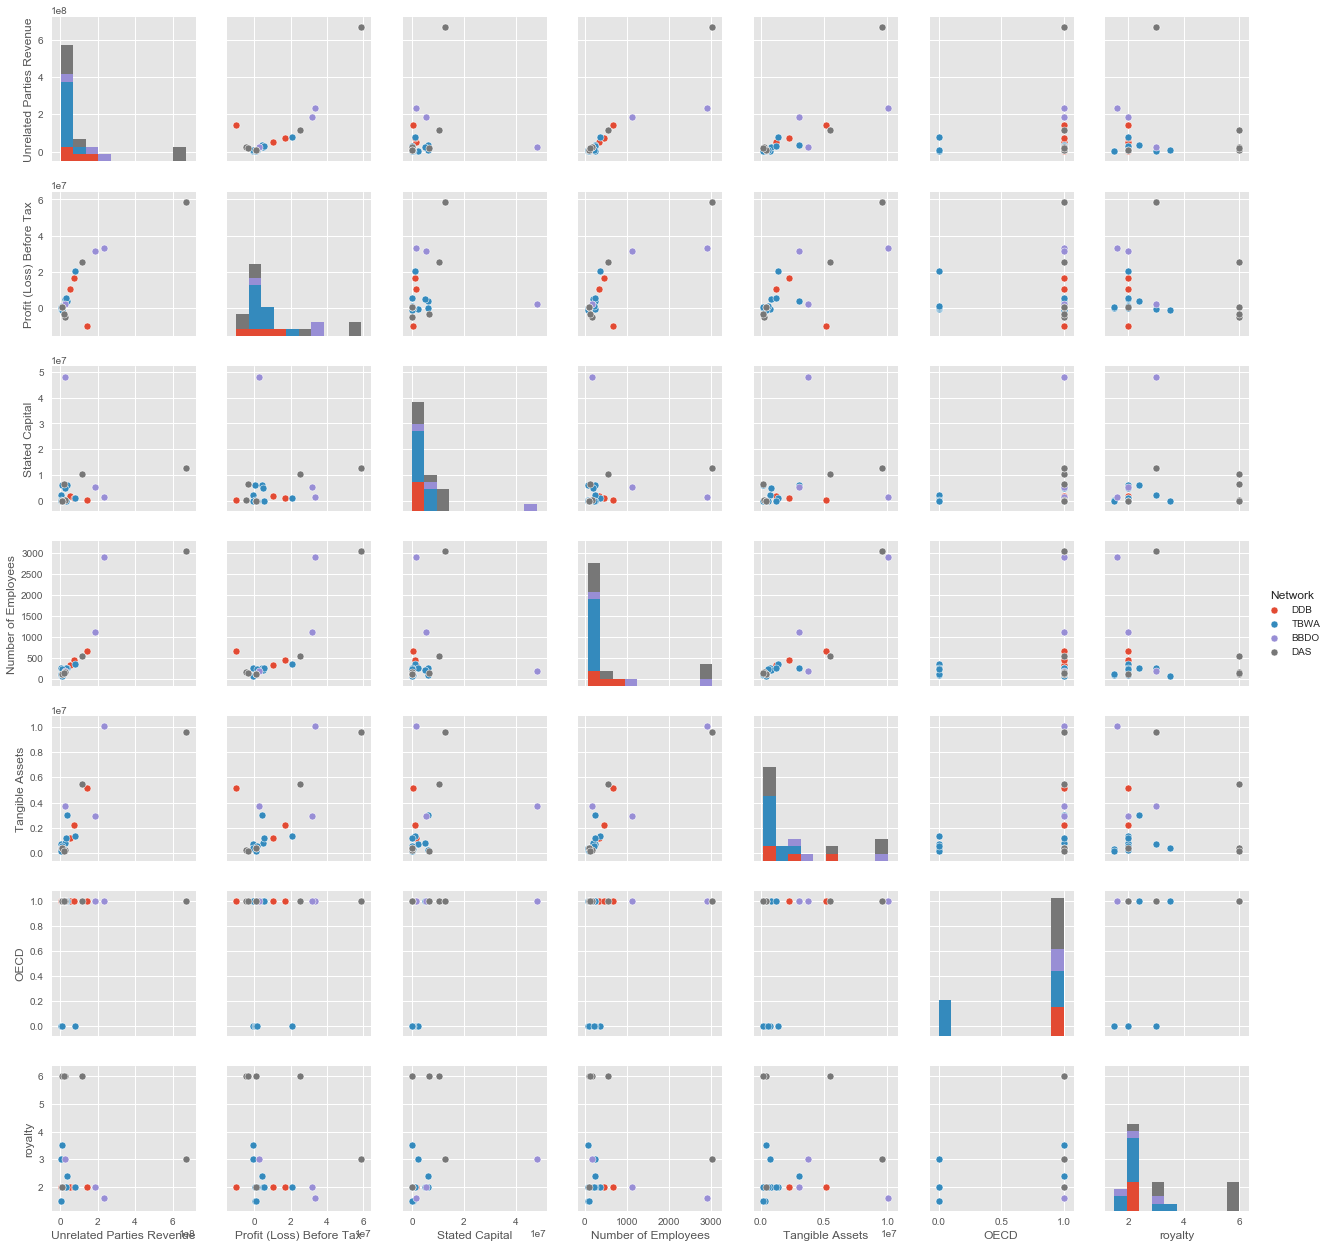

In [337]:
sns.pairplot(df[df['charge_royalty'] == 1][features + ['royalty', 'Network']], hue='Network')

In [334]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                royalty   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.540
Date:                Fri, 21 Jul 2017   Prob (F-statistic):           0.000234
Time:                        13:57:34   Log-Likelihood:                -312.56
No. Observations:                 220   AIC:                             637.1
Df Residuals:                     214   BIC:                             657.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Unrelated Parties Revenue -3.027e-10   7.74e-10     -0.391      0.696     -1.83e-09  1.22e-09
Profit (Loss) Before Tax   1.156e-09   9.94e-09      0.116      0.908     -1.84e-08  2.08e-08
Stated Capital             3.287e-09    4.5e-09      0.730      0.466     -5.59e-09  1.22e-08
Number of Employees           0.0003      0.000      1.416      0.158        -0.000     0.001
Tangible Assets           -1.702e-08   1.98e-08     -0.861      0.390      -5.6e-08  2.19e-08
OECD                          0.3400      0.097      3.513      0.001         0.149     0.531
==============================================================================
Omnibus:                      202.149   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2916.937
Skew:                           3.761   Prob(JB):                         0.00
Kurtosis:                      19.175   Cond. No.                     4.93e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Add ratios as features to regression model

In [247]:
features = [
    #'Unrelated Parties Revenue',
    #'Profit (Loss) Before Tax',
    #'Stated Capital',
    #'Number of Employees',
    #'Tangible Assets',
    #'CTRate',
    'ETR',
    #'TaxElasticity',
    'OM',
    #'RPInt',
    'AssetPerEE',
    'PBTPerEE',
    'ROC',
    'OECD',
]

In [248]:
X = df[features]
y = df['royalty']

In [249]:
# Handle infinities
X = X.replace(np.inf, 0.0).copy()
X = X.replace(-np.inf, 0.0).copy()

In [250]:
# Handle missing data
X = X.fillna(0)

In [251]:
model = linear_model.LinearRegression()

In [252]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [253]:
model.score(X, y)

0.030833773769037173

In [254]:
coefs = pd.DataFrame(data={'feature': X.columns, 'coef': model.coef_, 'abs_coef': np.abs(model.coef_)},
                     columns=['feature', 'coef', 'abs_coef'])
coefs.sort_values('abs_coef', ascending=False)

,feature,coef,abs_coef
5,OECD,2.641932e-01,2.641932e-01
0,ETR,3.173742e-03,3.173742e-03
1,OM,-1.393300e-03,1.393300e-03
2,AssetPerEE,2.171064e-05,2.171064e-05
4,ROC,-6.281209e-08,6.281209e-08
3,PBTPerEE,1.145008e-08,1.145008e-08


## Build decision tree classification model (`charge_royalty ~ .`)

In [255]:
from sklearn import tree

In [281]:
features = [
    'Unrelated Parties Revenue',
    'Profit (Loss) Before Tax',
    'Stated Capital',
    'Number of Employees',
    'Tangible Assets',
    #'CTRate',
    #'ETR',
    #'TaxElasticity',
    #'OM',
    #'RPInt',
    #'AssetPerEE',
    #'PBTPerEE',
    #'ROC',
    'OECD',
    'BBDO',
    'DDB',
    'DAS',
    'TBWA',
    'OMG',
]

In [282]:
X = df[features]
y = df['charge_royalty']

In [296]:
model = tree.DecisionTreeClassifier(max_depth=2)

In [297]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [298]:
model.score(X, y)

0.90909090909090906

In [299]:
import pydotplus
from IPython.display import Image

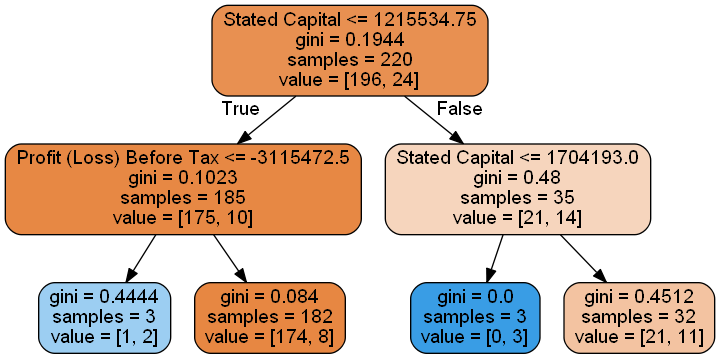

In [300]:
dot_data = tree.export_graphviz(
    model,
    out_file=None, 
    feature_names=X.columns,
    filled=True,
    rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

```
If capital > 1.7m then 33% are charged royalties (11 out of 32).
If capital between 1.2m and 1.7m then always charge royalties (3 out of 3).
If capital < 1.2m and profit < -3m then 66% charged royalties (2 out of 3).
Otherwise (capital < 1.2m and profit > -3m) 4% charged royalties (8 out of 182).
```

In [107]:
# gini: the lower the better, purity score, Value[x,y] X - number of countries in that leaf that has 0 royalty, Y is has royalty
# blue = charge royalty = 1, orange = 0 not charge royalty, light colour is skewing towards 1 or 0

### Repeat with 3 layer model

In [301]:
model = tree.DecisionTreeClassifier(max_depth=3)

In [302]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [303]:
model.score(X, y)

0.92272727272727273

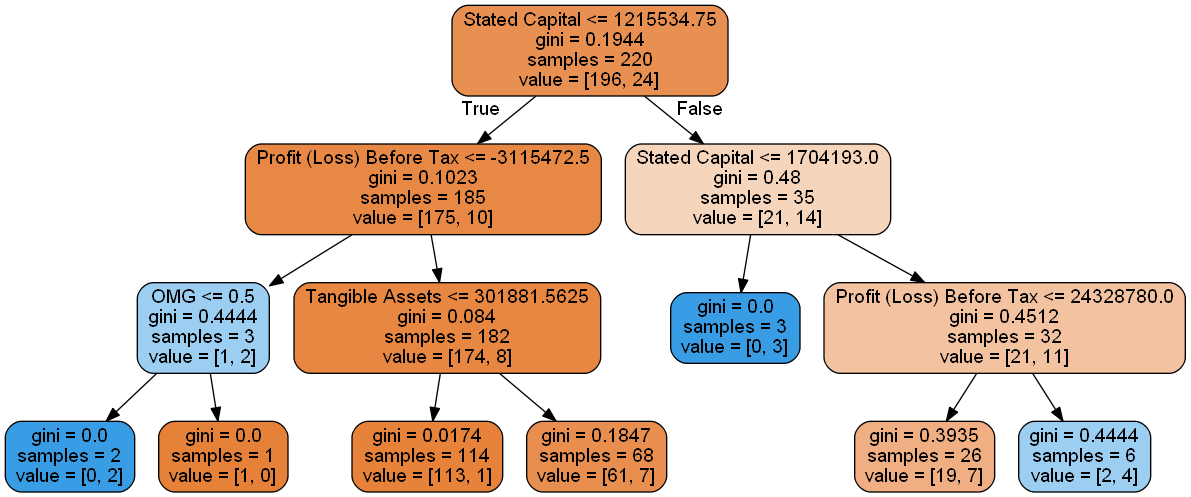

In [304]:
dot_data = tree.export_graphviz(
    model,
    out_file=None, 
    feature_names=X.columns,
    filled=True,
    rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

```
If capital > 1.7m AND PBT < 24m then 66% are charged royalties (4 out of 6).
If capital > 1.7m AND PBT > 24m then 27% are charged royalties (7 out of 26).
If capital between 1.2m and 1.7m then always charge royalties (3 out of 3).

If capital < 1.2m AND PBT > -3m AND assets > 300k then 10% charged royalties (7 out of 68).
If capital < 1.2m AND PBT > -3m AND assets < 300k then 0.9% charged royalties (1 out of 114).

If capital < 1.2m AND PBT < -3m AND is OMG then 66% charged royalties (2 out of 3).
```

In [107]:
# gini: the lower the better, purity score, Value[x,y] X - number of countries in that leaf that has 0 royalty, Y is has royalty
# blue = charge royalty = 1, orange = 0 not charge royalty, light colour is skewing towards 1 or 0

## This tree is probably suboptimal for describing this problem, find a better tree

In [305]:
from sklearn import model_selection

In [310]:
gs = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    cv=5,
    param_grid={
        'max_features': [2, 3, 4, 5, 6, 7, 10, None],
        'max_depth': [2, 3, 4, 5, 6, 7, 10],
        'min_samples_split': [2, 3, 4, 5, 6, 7, 10],
        'class_weight': [None, 'balanced'],
    },
    scoring='f1',
).fit(X, y)

C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

In [311]:
gs.best_params_

{'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 3,
 'min_samples_split': 10}

In [312]:
gs.best_score_

0.48354606122444688

### Repeat with "better" model

In [319]:
model = tree.DecisionTreeClassifier(max_depth=4, max_features=3, min_samples_split=10)

In [320]:
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [321]:
model.score(X, y)

0.90000000000000002

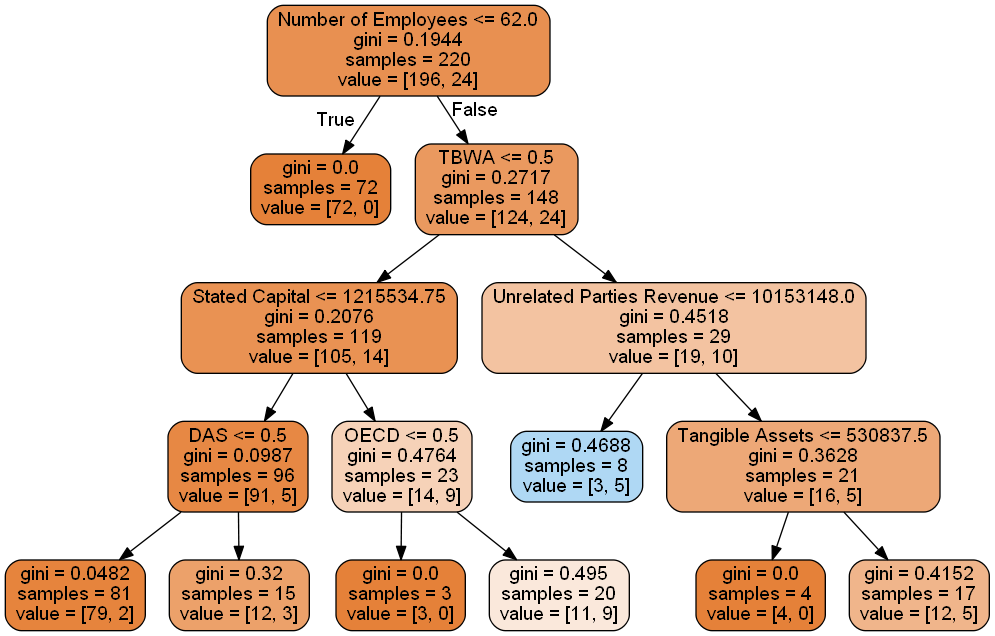

In [324]:
dot_data = tree.export_graphviz(
    model,
    out_file=None, 
    feature_names=X.columns,
    filled=True,
    rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png(), width=600)

```
If employees < 62 then don't charge (0 out of 72).

Otherwise (>62 employees)...
   ...if TBWA...
      ...Unrelated Parties Revenue > 10m AND Tangible Assets > 531k then don't charge (5 out of 17 charge).
      ...Unrelated Parties Revenue > 10m AND Tangible Assets < 531k then don't charge (0 out of 4 charge).
      ...Unrelated Parties Revenue < 10m then do charge (5 out of 8 charge).
  
  ...if not TBWA...
     ...Stated Capital > 1.2m AND OECD country then mixed (9 out of 20 charge).
     ...Stated Capital > 1.2m AND not OECD country then don't charge (0 out of 3 charge).
     
     ...Stated Capital < 1.2m AND DAS then don't charge (3 out of 15 charge).
     ...Stated Capital < 1.2m AND not DAS then don't charge (2 out of 81).
```